<a href="https://colab.research.google.com/github/dcpatton/credit-card-fraud-detection/blob/master/credit_card_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import random
import warnings
warnings.filterwarnings("ignore")

print(tf.__version__)

seed = 53
tf.random.set_seed(seed)
random.seed(seed)

2.8.2


# Prep Data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pip install kaggle --upgrade -q
!ls -l /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

-rw------- 1 root root 64 Jul 20 18:57 /root/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download mlg-ulb/creditcardfraud --unzip

 99% 65.0M/66.0M [00:00<00:00, 102MB/s] 
100% 66.0M/66.0M [00:00<00:00, 82.4MB/s]


In [ ]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [ ]:
# 0.17 % are fraudulent transactions
(492/(492+284315)) * 100

0.1727485630620034

Assuming the features were scaled before PCA. What type of scaling was used?

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, stratify=df['Class'], test_size=0.1, random_state=seed)
train, val = train_test_split(train, stratify=train['Class'], test_size=0.1, random_state=seed)
train.shape, val.shape, test.shape

((230693, 31), (25633, 31), (28481, 31))

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def prep_data(fit=False):
  x_train = train.drop(['Class'], axis='columns')
  x_val = val.drop(['Class'], axis='columns')
  x_test = test.drop(['Class'], axis='columns')
  if fit==True:
    x_train = scaler.fit_transform(x_train)
  else:
    x_train = scaler.transform(x_train)
  x_val = scaler.transform(x_val)
  x_test = scaler.transform(x_test)
  y_train = train['Class'].values
  y_val = val['Class'].values
  y_test = test['Class'].values
  return x_train, y_train, x_val, y_val, x_test, y_test

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = prep_data(fit=True)

In [ ]:
from numpy import bincount
neg, pos = bincount(y_train)
total = neg + pos

In [ ]:
def compute_metrics(y_true, y_pred):
  tp = tf.keras.metrics.TruePositives()
  tp.update_state(y_true, y_pred)
  tp = int(tp.result().numpy())
  fp = tf.keras.metrics.FalsePositives()
  fp.update_state(y_true, y_pred)
  fp = int(fp.result().numpy())
  tn = tf.keras.metrics.TrueNegatives()
  tn.update_state(y_true, y_pred)
  tn = int(tn.result().numpy())
  fn = tf.keras.metrics.FalseNegatives()
  fn.update_state(y_true, y_pred)
  fn = int(fn.result().numpy())
  return [tp, fn, fp, tn]

In [ ]:
tp_df = pd.DataFrame()
fn_df = pd.DataFrame()
fp_df = pd.DataFrame()
tn_df = pd.DataFrame()

In [ ]:
def print_metrics(metrics):
  print('Fraudulent Transactions Detected (True Positives): ' + str(metrics[0]))
  print('Fraudulent Transactions Missed (False Negatives): ' + str(metrics[1]))
  print('Legitimate Transactions Incorrectly Detected (False Positives): ' + str(metrics[2]))
  print('Legitimate Transactions Detected (True Negatives): ' + str(metrics[3]))

# Baseline

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=seed)
classifier.fit(x_train, y_train)

CPU times: user 4min 23s, sys: 14.9 ms, total: 4min 23s
Wall time: 2min 30s


In [ ]:
y_pred = classifier.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
RF_AUPRC = auprc.result().numpy()
RF_AUPRC

0.8183924

In [ ]:
RF_metrics = compute_metrics(y_test, y_pred)
print_metrics(RF_metrics)

Fraudulent Transactions Detected (True Positives): 41
Fraudulent Transactions Missed (False Negatives): 8
Legitimate Transactions Incorrectly Detected (False Positives): 1
Legitimate Transactions Detected (True Negatives): 28431


In [ ]:
%%time
from xgboost import XGBClassifier

xgbc = XGBClassifier(objective='binary:logistic', seed=seed, eval_metric='aucpr')
xgbc.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_val, y_val)])

[0]	validation_0-aucpr:0.744072	validation_1-aucpr:0.64036
[1]	validation_0-aucpr:0.782313	validation_1-aucpr:0.66218
[2]	validation_0-aucpr:0.781829	validation_1-aucpr:0.66218
[3]	validation_0-aucpr:0.783152	validation_1-aucpr:0.66218
[4]	validation_0-aucpr:0.786693	validation_1-aucpr:0.67477
[5]	validation_0-aucpr:0.791586	validation_1-aucpr:0.67401
[6]	validation_0-aucpr:0.797849	validation_1-aucpr:0.67765
[7]	validation_0-aucpr:0.805159	validation_1-aucpr:0.701834
[8]	validation_0-aucpr:0.810457	validation_1-aucpr:0.701825
[9]	validation_0-aucpr:0.811394	validation_1-aucpr:0.701265
[10]	validation_0-aucpr:0.818708	validation_1-aucpr:0.72255
[11]	validation_0-aucpr:0.819028	validation_1-aucpr:0.724171
[12]	validation_0-aucpr:0.819069	validation_1-aucpr:0.723691
[13]	validation_0-aucpr:0.822008	validation_1-aucpr:0.743557
[14]	validation_0-aucpr:0.823022	validation_1-aucpr:0.737261
[15]	validation_0-aucpr:0.825033	validation_1-aucpr:0.739812
[16]	validation_0-aucpr:0.827242	validatio

In [ ]:
y_pred = xgbc.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
XGB_AUPRC = auprc.result().numpy()
XGB_AUPRC

0.7611093

In [ ]:
XGB_metrics = compute_metrics(y_test, y_pred)
print_metrics(XGB_metrics)

Fraudulent Transactions Detected (True Positives): 40
Fraudulent Transactions Missed (False Negatives): 9
Legitimate Transactions Incorrectly Detected (False Positives): 3
Legitimate Transactions Detected (True Negatives): 28429


In [ ]:
from tensorflow.keras.layers import Dense, Input, ELU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

def create_model():
  tf.keras.backend.clear_session()
  input1 = Input(shape=(x_train.shape[1],), name='input1')
  x = Dense(96)(input1)
  x = BatchNormalization()(x)
  x = ELU()(x)
  x = Dropout(0.33)(x)
  x = Dense(96)(x)
  x = BatchNormalization()(x)
  x = ELU()(x)
  x = Dropout(0.33)(x)
  x = Dense(96)(x)
  x = BatchNormalization()(x)
  x = ELU()(x)
  x = Dropout(0.33)(x)
  out = Dense(1, activation='sigmoid', name='out')(x)

  _model = Model(inputs=[input1], outputs=[out])
  _model.summary()

  _model.compile(optimizer=Adam(), loss='binary_crossentropy', 
                 metrics=[tf.keras.metrics.AUC(curve='ROC', name='auroc'), 
                          tf.keras.metrics.AUC(curve='PR', name='auprc')])
  return _model

model = create_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input1 (InputLayer)         [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 96)                2976      
                                                                 
 batch_normalization (BatchN  (None, 96)               384       
 ormalization)                                                   
                                                                 
 elu (ELU)                   (None, 96)                0         
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 96)                9312      
                                                             

In [ ]:
BATCH_SIZE=256

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_auprc', patience=10, verbose=1, mode='max',
                   restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=200, verbose=2, callbacks=[es], 
                    validation_data=(x_val, y_val), batch_size=BATCH_SIZE)

Epoch 1/200
902/902 - 6s - loss: 0.0603 - auroc: 0.8316 - auprc: 0.3092 - val_loss: 0.0079 - val_auroc: 0.9306 - val_auprc: 0.6650 - 6s/epoch - 7ms/step
Epoch 2/200
902/902 - 4s - loss: 0.0065 - auroc: 0.9042 - auprc: 0.6277 - val_loss: 0.0064 - val_auroc: 0.9088 - val_auprc: 0.6470 - 4s/epoch - 5ms/step
Epoch 3/200
902/902 - 4s - loss: 0.0052 - auroc: 0.9115 - auprc: 0.6556 - val_loss: 0.0061 - val_auroc: 0.9202 - val_auprc: 0.6553 - 4s/epoch - 5ms/step
Epoch 4/200
902/902 - 4s - loss: 0.0045 - auroc: 0.9215 - auprc: 0.7172 - val_loss: 0.0053 - val_auroc: 0.9087 - val_auprc: 0.6475 - 4s/epoch - 5ms/step
Epoch 5/200
902/902 - 5s - loss: 0.0041 - auroc: 0.9307 - auprc: 0.7157 - val_loss: 0.0044 - val_auroc: 0.9201 - val_auprc: 0.7153 - 5s/epoch - 5ms/step
Epoch 6/200
902/902 - 4s - loss: 0.0039 - auroc: 0.9334 - auprc: 0.7322 - val_loss: 0.0043 - val_auroc: 0.9200 - val_auprc: 0.6827 - 4s/epoch - 5ms/step
Epoch 7/200
902/902 - 4s - loss: 0.0036 - auroc: 0.9299 - auprc: 0.7535 - val_loss

In [ ]:
model.evaluate(x_test, y_test)

891/891 [==============================] - 3s 3ms/step - loss: 0.0028 - auroc: 0.9283 - auprc: 0.8535


[0.0027969060465693474, 0.9282847046852112, 0.8535040020942688]

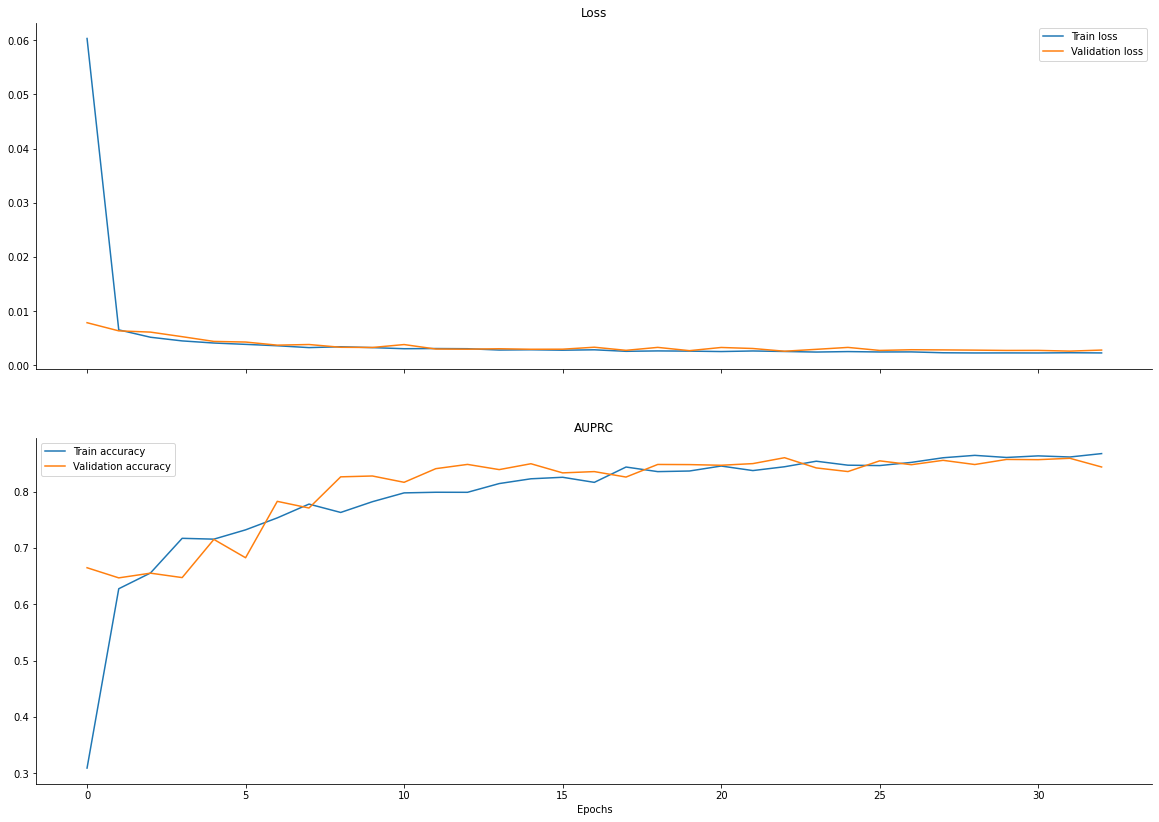

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['auprc'], label='Train accuracy')
ax2.plot(history['val_auprc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('AUPRC')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [ ]:
y_pred = model.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
TF_Model_AUPRC = auprc.result().numpy()
TF_Model_AUPRC

0.853504

In [ ]:
TF_Model_metrics = compute_metrics(y_test, y_pred)
print_metrics(TF_Model_metrics)

Fraudulent Transactions Detected (True Positives): 40
Fraudulent Transactions Missed (False Negatives): 9
Legitimate Transactions Incorrectly Detected (False Positives): 4
Legitimate Transactions Detected (True Negatives): 28428


In [ ]:
print('Random Forest ********************')
print_metrics(RF_metrics)
print('XGBoost **************************')
print_metrics(XGB_metrics)
print('TensorFlow DNN Model *************')
print_metrics(TF_Model_metrics)

Random Forest ********************
Fraudulent Transactions Detected (True Positives): 41
Fraudulent Transactions Missed (False Negatives): 8
Legitimate Transactions Incorrectly Detected (False Positives): 1
Legitimate Transactions Detected (True Negatives): 28431
XGBoost **************************
Fraudulent Transactions Detected (True Positives): 40
Fraudulent Transactions Missed (False Negatives): 9
Legitimate Transactions Incorrectly Detected (False Positives): 3
Legitimate Transactions Detected (True Negatives): 28429
TensorFlow DNN Model *************
Fraudulent Transactions Detected (True Positives): 40
Fraudulent Transactions Missed (False Negatives): 9
Legitimate Transactions Incorrectly Detected (False Positives): 4
Legitimate Transactions Detected (True Negatives): 28428


In [ ]:
models = ['RandomForest', 'XGBoost', 'TensorFlow DNN']
tp_df['Model'] = models
results = [RF_metrics[0], XGB_metrics[0], TF_Model_metrics[0]]
tp_df['baseline'] = results
fn_df['Model'] = models
results = [RF_metrics[1], XGB_metrics[1], TF_Model_metrics[1]]
fn_df['baseline'] = results
fp_df['Model'] = models
results = [RF_metrics[2], XGB_metrics[2], TF_Model_metrics[2]]
fp_df['baseline'] = results
tn_df['Model'] = models
results = [RF_metrics[3], XGB_metrics[3], TF_Model_metrics[3]]
tn_df['baseline'] = results

In [ ]:
auprc_df = pd.DataFrame()
results = [RF_AUPRC, XGB_AUPRC, TF_Model_AUPRC]
auprc_df['Model'] = models
auprc_df['baseline'] = results

# Class Weighting
Try to improve this by having our loss function focus more on the minority class. We will do this with class weights during model fitting.

In [ ]:
# The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as 
# n_samples / (n_classes * np.bincount(y))

# The “balanced_subsample” mode is the same as “balanced” except that weights are computed based on the bootstrap sample for every tree grown.

classifier = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=seed)
classifier.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=53)

In [ ]:
y_pred = classifier.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
RF_AUPRC = auprc.result().numpy()
RF_AUPRC

0.77792966

In [ ]:
RF_metrics = compute_metrics(y_test, y_pred)
print_metrics(RF_metrics)

Fraudulent Transactions Detected (True Positives): 39
Fraudulent Transactions Missed (False Negatives): 10
Legitimate Transactions Incorrectly Detected (False Positives): 1
Legitimate Transactions Detected (True Negatives): 28431


In [ ]:
from math import sqrt
scale_pos_weight = sqrt(neg/pos) 

xgbc = XGBClassifier(objective='binary:logistic', seed=seed, eval_metric='aucpr',
                     scale_pos_weight=scale_pos_weight)
xgbc.fit(x_train, y_train)

XGBClassifier(eval_metric='aucpr', scale_pos_weight=24.02452798416975, seed=53)

In [ ]:
y_pred = xgbc.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
XGB_AUPRC = auprc.result().numpy()
XGB_AUPRC

0.60337055

In [ ]:
XGB_metrics = compute_metrics(y_test, y_pred)
print_metrics(XGB_metrics)

Fraudulent Transactions Detected (True Positives): 41
Fraudulent Transactions Missed (False Negatives): 8
Legitimate Transactions Incorrectly Detected (False Positives): 16
Legitimate Transactions Detected (True Negatives): 28416


In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

class_weight = {0: weight_for_0, 1: weight_for_1}

model = create_model()

Weight for class 0: 0.50
Weight for class 1: 289.09
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input1 (InputLayer)         [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 96)                2976      
                                                                 
 batch_normalization (BatchN  (None, 96)               384       
 ormalization)                                                   
                                                                 
 elu (ELU)                   (None, 96)                0         
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 96)                9312      
         

In [ ]:
es = EarlyStopping(monitor='val_auprc', patience=30, verbose=1, mode='max',
                   restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=200, verbose=2, callbacks=[es], 
                    validation_data=(x_val, y_val), class_weight=class_weight, 
                    batch_size=BATCH_SIZE)

Epoch 1/200
902/902 - 6s - loss: 0.2843 - auroc: 0.9487 - auprc: 0.3165 - val_loss: 0.1441 - val_auroc: 0.9819 - val_auprc: 0.4293 - 6s/epoch - 7ms/step
Epoch 2/200
902/902 - 5s - loss: 0.1992 - auroc: 0.9694 - auprc: 0.3579 - val_loss: 0.1075 - val_auroc: 0.9873 - val_auprc: 0.6035 - 5s/epoch - 5ms/step
Epoch 3/200
902/902 - 5s - loss: 0.1788 - auroc: 0.9767 - auprc: 0.4339 - val_loss: 0.1836 - val_auroc: 0.9896 - val_auprc: 0.4385 - 5s/epoch - 5ms/step
Epoch 4/200
902/902 - 5s - loss: 0.1881 - auroc: 0.9762 - auprc: 0.4589 - val_loss: 0.0960 - val_auroc: 0.9815 - val_auprc: 0.6014 - 5s/epoch - 5ms/step
Epoch 5/200
902/902 - 5s - loss: 0.1711 - auroc: 0.9775 - auprc: 0.6034 - val_loss: 0.1120 - val_auroc: 0.9846 - val_auprc: 0.6158 - 5s/epoch - 5ms/step
Epoch 6/200
902/902 - 5s - loss: 0.1463 - auroc: 0.9844 - auprc: 0.5926 - val_loss: 0.0973 - val_auroc: 0.9883 - val_auprc: 0.6616 - 5s/epoch - 5ms/step
Epoch 7/200
902/902 - 5s - loss: 0.1403 - auroc: 0.9865 - auprc: 0.5675 - val_loss

In [ ]:
model.evaluate(x_test, y_test)

891/891 [==============================] - 3s 3ms/step - loss: 0.0762 - auroc: 0.9888 - auprc: 0.6846


[0.07616373151540756, 0.9888150691986084, 0.6846405863761902]

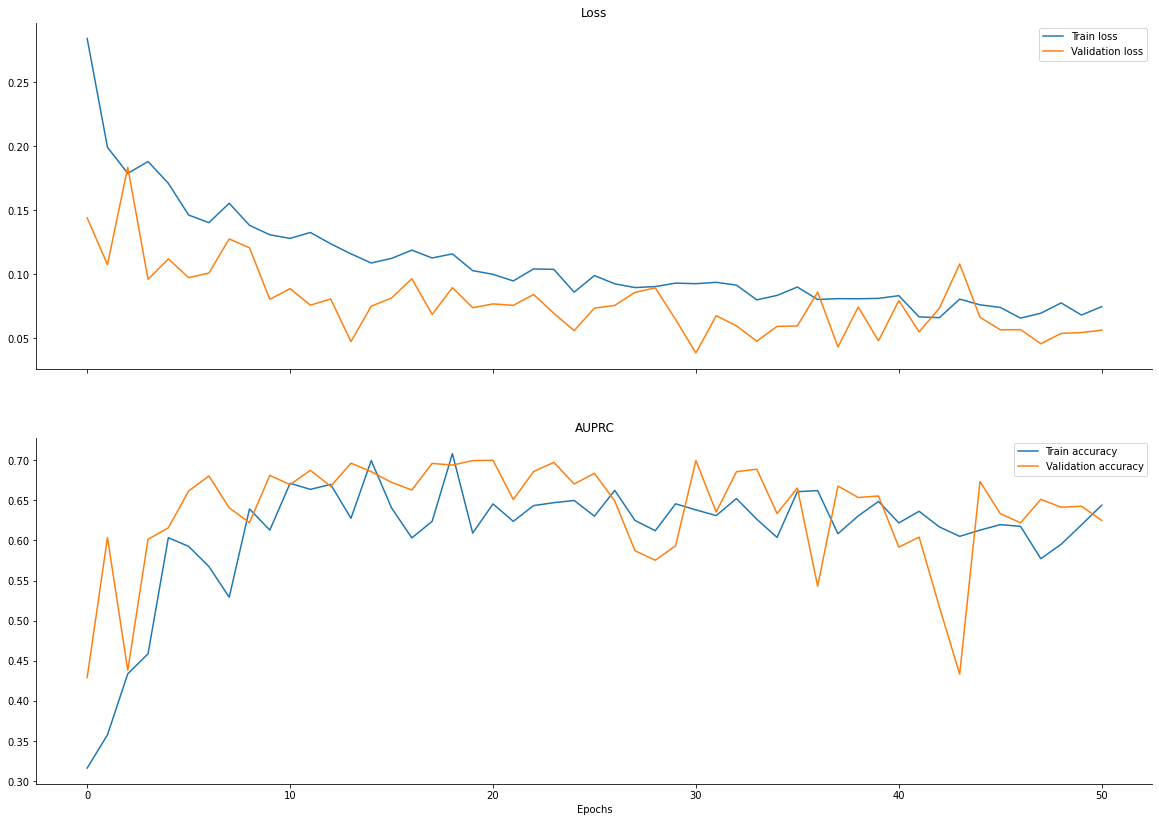

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['auprc'], label='Train accuracy')
ax2.plot(history['val_auprc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('AUPRC')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [ ]:
y_pred = model.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
TF_Model_AUPRC = auprc.result().numpy()
TF_Model_AUPRC

0.6846406

In [ ]:
TF_Model_metrics = compute_metrics(y_test, y_pred)
print_metrics(TF_Model_metrics)

Fraudulent Transactions Detected (True Positives): 43
Fraudulent Transactions Missed (False Negatives): 6
Legitimate Transactions Incorrectly Detected (False Positives): 690
Legitimate Transactions Detected (True Negatives): 27742


In [ ]:
print('RF_AUPRC: ' + str(RF_AUPRC))
print('XGB_AUPRC: ' + str(XGB_AUPRC))
print('TF_Model_AUPRC: ' + str(TF_Model_AUPRC))

RF_AUPRC: 0.77792966
XGB_AUPRC: 0.60337055
TF_Model_AUPRC: 0.6846406


In [ ]:
print('Random Forest ********************')
print_metrics(RF_metrics)
print('XGBoost **************************')
print_metrics(XGB_metrics)
print('TensorFlow DNN Model ************')
print_metrics(TF_Model_metrics)


Random Forest ********************
Fraudulent Transactions Detected (True Positives): 39
Fraudulent Transactions Missed (False Negatives): 10
Legitimate Transactions Incorrectly Detected (False Positives): 1
Legitimate Transactions Detected (True Negatives): 28431
XGBoost **************************
Fraudulent Transactions Detected (True Positives): 41
Fraudulent Transactions Missed (False Negatives): 8
Legitimate Transactions Incorrectly Detected (False Positives): 16
Legitimate Transactions Detected (True Negatives): 28416
TensorFlow DNN Model ************
Fraudulent Transactions Detected (True Positives): 43
Fraudulent Transactions Missed (False Negatives): 6
Legitimate Transactions Incorrectly Detected (False Positives): 690
Legitimate Transactions Detected (True Negatives): 27742


So we are improving on Recall, but worse on Precision



In [ ]:
tp_df['Model'] = models
results = [RF_metrics[0], XGB_metrics[0], TF_Model_metrics[0]]
tp_df['class weighted'] = results
fn_df['Model'] = models
results = [RF_metrics[1], XGB_metrics[1], TF_Model_metrics[1]]
fn_df['class weighted'] = results
fp_df['Model'] = models
results = [RF_metrics[2], XGB_metrics[2], TF_Model_metrics[2]]
fp_df['class weighted'] = results
tn_df['Model'] = models
results = [RF_metrics[3], XGB_metrics[3], TF_Model_metrics[3]]
tn_df['class weighted'] = results

In [ ]:
results = [RF_AUPRC, XGB_AUPRC, TF_Model_AUPRC]
auprc_df['class weighted'] = results

# Undersampling (Random)

In [ ]:
import imblearn
imblearn.__version__

'0.8.1'

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = prep_data()

from numpy import bincount
neg, pos = bincount(y_train)
print('Original balance: ' + str(neg) + ' non-fraud, ' + str(pos) + ' fraud')

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=seed)
x_train, y_train = rus.fit_resample(x_train, y_train)

neg, pos = bincount(y_train)
print('New balance: ' + str(neg) + ' non-fraud, ' + str(pos) + ' fraud')

Original balance: 230294 non-fraud, 399 fraud
New balance: 399 non-fraud, 399 fraud


In [ ]:
classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=seed)
classifier.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=53)

In [ ]:
columns = train.columns.to_list()
columns.remove('Class')
print("The Features Importance are: ")  
for feature, value in zip(columns, classifier.feature_importances_):
        print(feature, value)

The Features Importance are: 
Time 0.0036744282872588465
V1 0.007721844196486206
V2 0.023750228094047237
V3 0.0529755975469737
V4 0.10828660894422383
V5 0.007884729475438931
V6 0.018611606108049294
V7 0.0614997715755408
V8 0.01042431099576732
V9 0.015386858574537017
V10 0.09851057050191539
V11 0.047926039024779286
V12 0.08958684626640849
V13 0.008488036727374778
V14 0.21881762621259132
V15 0.006919781369908638
V16 0.050807560582725744
V17 0.06812601430249592
V18 0.006204462223725774
V19 0.015814475289194087
V20 0.008065364814657243
V21 0.011489096091259397
V22 0.004456756122211701
V23 0.0077402561434883055
V24 0.006252842805145676
V25 0.006771086117338083
V26 0.006634546881595723
V27 0.006409502767302248
V28 0.00870776046151028
Amount 0.012055391496048774


In [ ]:
y_pred = classifier.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
RF_AUPRC = auprc.result().numpy()
RF_AUPRC

0.043756925

In [ ]:
RF_metrics = compute_metrics(y_test, y_pred)
print_metrics(RF_metrics)

Fraudulent Transactions Detected (True Positives): 44
Fraudulent Transactions Missed (False Negatives): 5
Legitimate Transactions Incorrectly Detected (False Positives): 871
Legitimate Transactions Detected (True Negatives): 27561


In [ ]:
xgbc = XGBClassifier(objective='binary:logistic', seed=seed, eval_metric='aucpr')
xgbc.fit(x_train, y_train)

XGBClassifier(eval_metric='aucpr', seed=53)

In [ ]:
y_pred = xgbc.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
XGB_AUPRC = auprc.result().numpy()
XGB_AUPRC

0.034514435

In [ ]:
XGB_metrics = compute_metrics(y_test, y_pred)
print_metrics(XGB_metrics)

Fraudulent Transactions Detected (True Positives): 44
Fraudulent Transactions Missed (False Negatives): 5
Legitimate Transactions Incorrectly Detected (False Positives): 1119
Legitimate Transactions Detected (True Negatives): 27313


In [ ]:
model = create_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input1 (InputLayer)         [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 96)                2976      
                                                                 
 batch_normalization (BatchN  (None, 96)               384       
 ormalization)                                                   
                                                                 
 elu (ELU)                   (None, 96)                0         
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 96)                9312      
                                                             

In [ ]:
es = EarlyStopping(monitor='val_auprc', patience=30, verbose=1, mode='max',
                   restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=200, verbose=2, callbacks=[es], 
                    validation_data=(x_val, y_val), batch_size=8)

Epoch 1/200
100/100 - 10s - loss: 0.4269 - auroc: 0.8894 - auprc: 0.9173 - val_loss: 0.1081 - val_auroc: 0.9774 - val_auprc: 0.5597 - 10s/epoch - 101ms/step
Epoch 2/200
100/100 - 11s - loss: 0.3306 - auroc: 0.9279 - auprc: 0.9466 - val_loss: 0.0628 - val_auroc: 0.9716 - val_auprc: 0.4490 - 11s/epoch - 107ms/step
Epoch 3/200
100/100 - 11s - loss: 0.2982 - auroc: 0.9451 - auprc: 0.9541 - val_loss: 0.0385 - val_auroc: 0.9763 - val_auprc: 0.5682 - 11s/epoch - 107ms/step
Epoch 4/200
100/100 - 11s - loss: 0.3105 - auroc: 0.9380 - auprc: 0.9527 - val_loss: 0.0635 - val_auroc: 0.9781 - val_auprc: 0.5934 - 11s/epoch - 107ms/step
Epoch 5/200
100/100 - 11s - loss: 0.2878 - auroc: 0.9445 - auprc: 0.9575 - val_loss: 0.0650 - val_auroc: 0.9800 - val_auprc: 0.6546 - 11s/epoch - 107ms/step
Epoch 6/200
100/100 - 11s - loss: 0.3107 - auroc: 0.9396 - auprc: 0.9504 - val_loss: 0.0836 - val_auroc: 0.9831 - val_auprc: 0.6319 - 11s/epoch - 107ms/step
Epoch 7/200
100/100 - 11s - loss: 0.2646 - auroc: 0.9508 -

In [ ]:
model.evaluate(x_test, y_test)

891/891 [==============================] - 3s 3ms/step - loss: 0.0941 - auroc: 0.9820 - auprc: 0.6410


[0.09405727684497833, 0.9819669127464294, 0.6409993171691895]

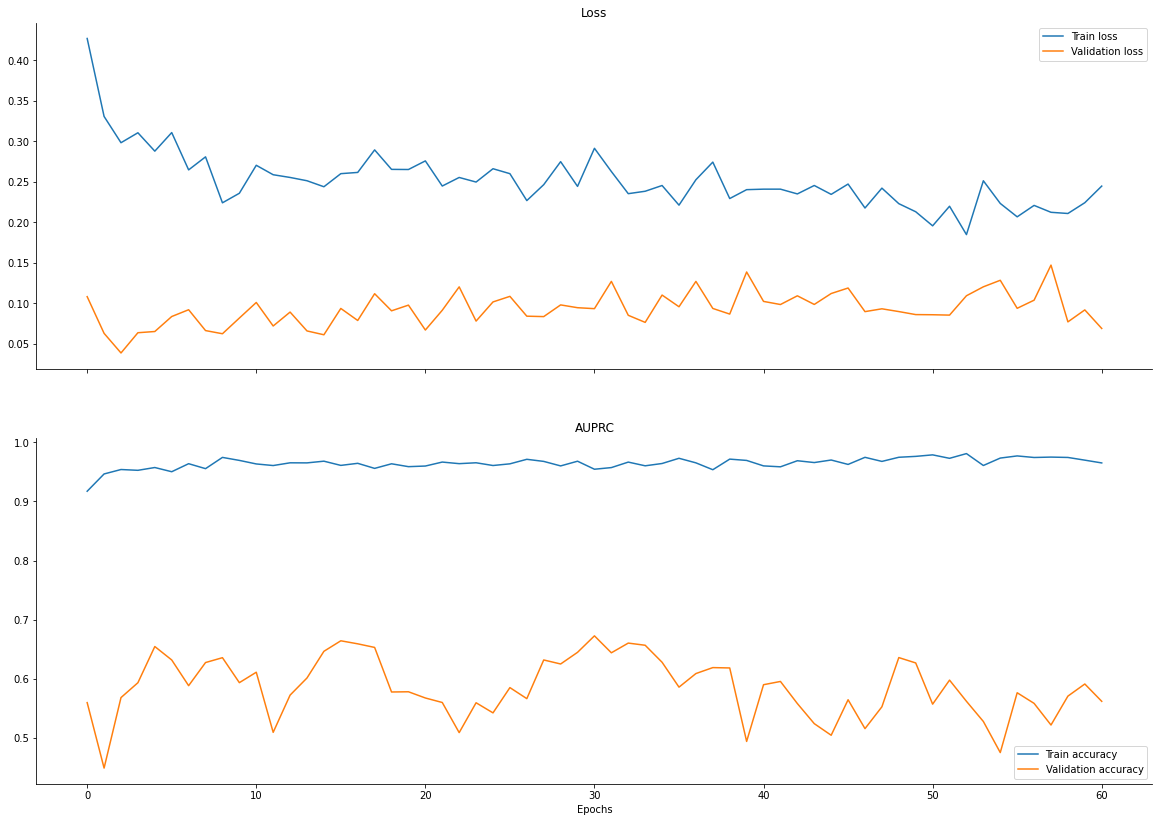

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['auprc'], label='Train accuracy')
ax2.plot(history['val_auprc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('AUPRC')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [ ]:
y_pred = model.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
TF_Model_AUPRC = auprc.result().numpy()
TF_Model_AUPRC

0.6409993

In [ ]:
TF_Model_metrics = compute_metrics(y_test, y_pred)
print_metrics(TF_Model_metrics)

Fraudulent Transactions Detected (True Positives): 43
Fraudulent Transactions Missed (False Negatives): 6
Legitimate Transactions Incorrectly Detected (False Positives): 333
Legitimate Transactions Detected (True Negatives): 28099


In [ ]:
print('RF_AUPRC: ' + str(RF_AUPRC))
print('XGB_AUPRC: ' + str(XGB_AUPRC))
print('TF_Model_AUPRC: ' + str(TF_Model_AUPRC))

RF_AUPRC: 0.043756925
XGB_AUPRC: 0.034514435
TF_Model_AUPRC: 0.6409993


In [ ]:
print('Random Forest ********************')
print_metrics(RF_metrics)
print('XGBoost **************************')
print_metrics(XGB_metrics)
print('TensorFlow DNN Model1 ************')
print_metrics(TF_Model_metrics)

Random Forest ********************
Fraudulent Transactions Detected (True Positives): 44
Fraudulent Transactions Missed (False Negatives): 5
Legitimate Transactions Incorrectly Detected (False Positives): 871
Legitimate Transactions Detected (True Negatives): 27561
XGBoost **************************
Fraudulent Transactions Detected (True Positives): 44
Fraudulent Transactions Missed (False Negatives): 5
Legitimate Transactions Incorrectly Detected (False Positives): 1119
Legitimate Transactions Detected (True Negatives): 27313
TensorFlow DNN Model1 ************
Fraudulent Transactions Detected (True Positives): 43
Fraudulent Transactions Missed (False Negatives): 6
Legitimate Transactions Incorrectly Detected (False Positives): 333
Legitimate Transactions Detected (True Negatives): 28099


In [ ]:
tp_df['Model'] = models
results = [RF_metrics[0], XGB_metrics[0], TF_Model_metrics[0]]
tp_df['Undersampling (Random)'] = results
fn_df['Model'] = models
results = [RF_metrics[1], XGB_metrics[1], TF_Model_metrics[1]]
fn_df['Undersampling (Random)'] = results
fp_df['Model'] = models
results = [RF_metrics[2], XGB_metrics[2], TF_Model_metrics[2]]
fp_df['Undersampling (Random)'] = results
tn_df['Model'] = models
results = [RF_metrics[3], XGB_metrics[3], TF_Model_metrics[3]]
tn_df['Undersampling (Random)'] = results

In [ ]:
results = [RF_AUPRC, XGB_AUPRC, TF_Model_AUPRC]
auprc_df['Undersampling (Random)'] = results

# Undersampling (NearMiss)

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = prep_data()

from numpy import bincount
neg, pos = bincount(y_train)
print('Original balance: ' + str(neg) + ' non-fraud, ' + str(pos) + ' fraud')

from imblearn.under_sampling import NearMiss
nm1 = NearMiss(version=1)
x_train, y_train = nm1.fit_resample(x_train, y_train)

neg, pos = bincount(y_train)
print('New balance: ' + str(neg) + ' non-fraud, ' + str(pos) + ' fraud')

Original balance: 230294 non-fraud, 399 fraud
New balance: 399 non-fraud, 399 fraud


In [ ]:
# fraud_df = train_df.loc[df['Class'] == 1]
# non_fraud_df = train_df.loc[df['Class'] == 0][:len(fraud_df)]

# balanced_df = pd.concat([fraud_df, non_fraud_df])

# # Shuffle
# balanced_df = balanced_df.sample(frac=1, random_state=seed).reset_index(drop=True)

# balanced_df.head()

In [ ]:
# y_train = balanced_df['Class'].values
# x_train = balanced_df.drop(['Class'], axis='columns')
# x_train = x_train.values

In [ ]:
classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=seed)
classifier.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=53)

In [ ]:
y_pred = classifier.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
RF_AUPRC = auprc.result().numpy()
RF_AUPRC

0.001687999

In [ ]:
RF_metrics = compute_metrics(y_test, y_pred)
print_metrics(RF_metrics)

Fraudulent Transactions Detected (True Positives): 46
Fraudulent Transactions Missed (False Negatives): 3
Legitimate Transactions Incorrectly Detected (False Positives): 27222
Legitimate Transactions Detected (True Negatives): 1210


In [ ]:
xgbc = XGBClassifier(objective='binary:logistic', seed=seed, eval_metric='aucpr')
xgbc.fit(x_train, y_train)

XGBClassifier(eval_metric='aucpr', seed=53)

In [ ]:
y_pred = xgbc.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
XGB_AUPRC = auprc.result().numpy()
XGB_AUPRC

0.0019576792

In [ ]:
XGB_metrics = compute_metrics(y_test, y_pred)
print_metrics(XGB_metrics)

Fraudulent Transactions Detected (True Positives): 47
Fraudulent Transactions Missed (False Negatives): 2
Legitimate Transactions Incorrectly Detected (False Positives): 23897
Legitimate Transactions Detected (True Negatives): 4535


In [ ]:
model = create_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input1 (InputLayer)         [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 96)                2976      
                                                                 
 batch_normalization (BatchN  (None, 96)               384       
 ormalization)                                                   
                                                                 
 elu (ELU)                   (None, 96)                0         
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 96)                9312      
                                                             

In [ ]:
es = EarlyStopping(monitor='val_auprc', patience=30, verbose=1, mode='max',
                   restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=200, verbose=2, callbacks=[es], 
                    validation_data=(x_val, y_val), batch_size=8)

Epoch 1/200
100/100 - 10s - loss: 0.3906 - auroc: 0.9098 - auprc: 0.9175 - val_loss: 0.1395 - val_auroc: 0.9666 - val_auprc: 0.4718 - 10s/epoch - 104ms/step
Epoch 2/200
100/100 - 8s - loss: 0.2943 - auroc: 0.9452 - auprc: 0.9494 - val_loss: 0.1591 - val_auroc: 0.9403 - val_auprc: 0.2761 - 8s/epoch - 85ms/step
Epoch 3/200
100/100 - 8s - loss: 0.2496 - auroc: 0.9623 - auprc: 0.9652 - val_loss: 0.1599 - val_auroc: 0.9424 - val_auprc: 0.2468 - 8s/epoch - 83ms/step
Epoch 4/200
100/100 - 11s - loss: 0.2599 - auroc: 0.9581 - auprc: 0.9610 - val_loss: 0.3934 - val_auroc: 0.9224 - val_auprc: 0.1086 - 11s/epoch - 107ms/step
Epoch 5/200
100/100 - 9s - loss: 0.2386 - auroc: 0.9623 - auprc: 0.9688 - val_loss: 0.2718 - val_auroc: 0.9335 - val_auprc: 0.1844 - 9s/epoch - 85ms/step
Epoch 6/200
100/100 - 11s - loss: 0.3063 - auroc: 0.9449 - auprc: 0.9530 - val_loss: 0.3504 - val_auroc: 0.9334 - val_auprc: 0.1328 - 11s/epoch - 107ms/step
Epoch 7/200
100/100 - 11s - loss: 0.2552 - auroc: 0.9549 - auprc: 0

In [ ]:
model.evaluate(x_test, y_test)

891/891 [==============================] - 3s 3ms/step - loss: 0.1401 - auroc: 0.9516 - auprc: 0.4986


[0.14005695283412933, 0.9515675902366638, 0.49857357144355774]

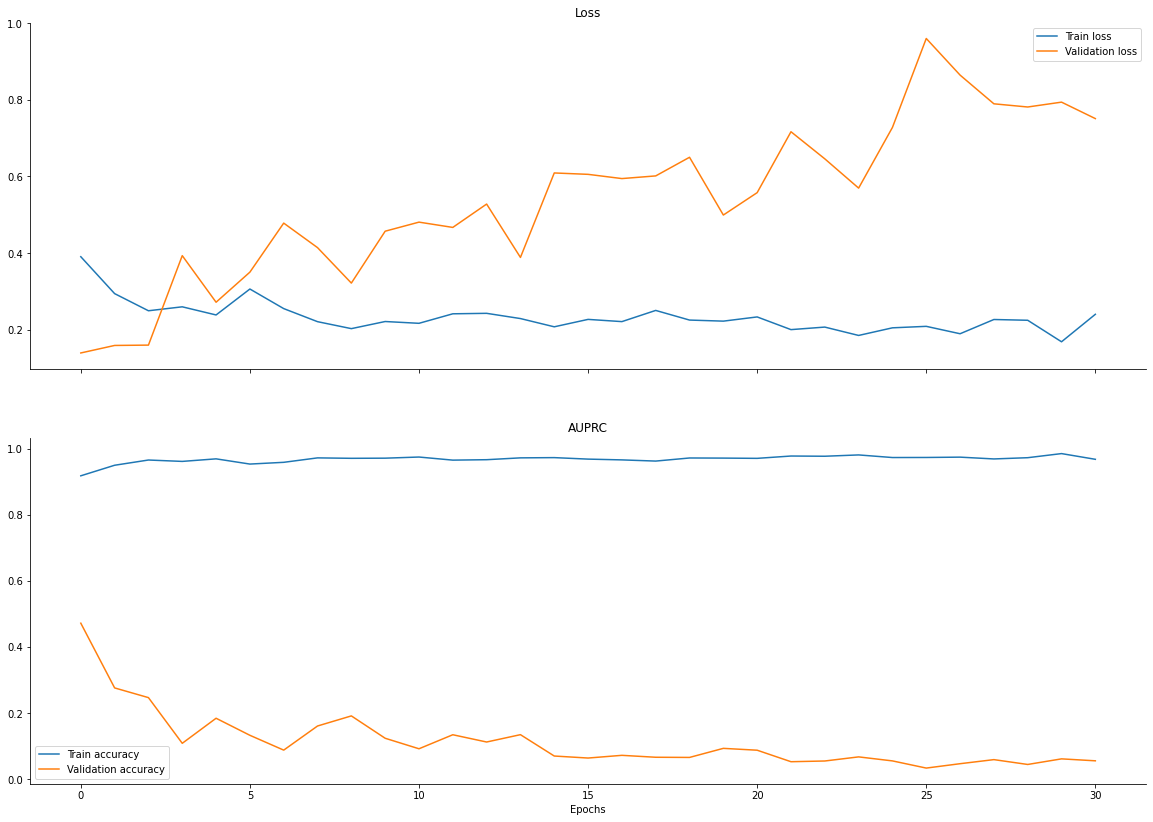

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['auprc'], label='Train accuracy')
ax2.plot(history['val_auprc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('AUPRC')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [ ]:
y_pred = model.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
TF_Model_AUPRC = auprc.result().numpy()
TF_Model_AUPRC

0.49857357

In [ ]:
TF_Model_metrics = compute_metrics(y_test, y_pred)
print_metrics(TF_Model_metrics)

Fraudulent Transactions Detected (True Positives): 43
Fraudulent Transactions Missed (False Negatives): 6
Legitimate Transactions Incorrectly Detected (False Positives): 455
Legitimate Transactions Detected (True Negatives): 27977


In [ ]:
print('RF_AUPRC: ' + str(RF_AUPRC))
print('XGB_AUPRC: ' + str(XGB_AUPRC))
print('TF_Model_AUPRC: ' + str(TF_Model_AUPRC))

RF_AUPRC: 0.001687999
XGB_AUPRC: 0.0019576792
TF_Model_AUPRC: 0.49857357


In [ ]:
print('Random Forest ********************')
print_metrics(RF_metrics)
print('XGBoost **************************')
print_metrics(XGB_metrics)
print('TensorFlow DNN Model1 ************')
print_metrics(TF_Model_metrics)

Random Forest ********************
Fraudulent Transactions Detected (True Positives): 46
Fraudulent Transactions Missed (False Negatives): 3
Legitimate Transactions Incorrectly Detected (False Positives): 27222
Legitimate Transactions Detected (True Negatives): 1210
XGBoost **************************
Fraudulent Transactions Detected (True Positives): 47
Fraudulent Transactions Missed (False Negatives): 2
Legitimate Transactions Incorrectly Detected (False Positives): 23897
Legitimate Transactions Detected (True Negatives): 4535
TensorFlow DNN Model1 ************
Fraudulent Transactions Detected (True Positives): 43
Fraudulent Transactions Missed (False Negatives): 6
Legitimate Transactions Incorrectly Detected (False Positives): 455
Legitimate Transactions Detected (True Negatives): 27977


In [ ]:
tp_df['Model'] = models
results = [RF_metrics[0], XGB_metrics[0], TF_Model_metrics[0]]
tp_df['Undersampling (NearMiss)'] = results
fn_df['Model'] = models
results = [RF_metrics[1], XGB_metrics[1], TF_Model_metrics[1]]
fn_df['Undersampling (NearMiss)'] = results
fp_df['Model'] = models
results = [RF_metrics[2], XGB_metrics[2], TF_Model_metrics[2]]
fp_df['Undersampling (NearMiss)'] = results
tn_df['Model'] = models
results = [RF_metrics[3], XGB_metrics[3], TF_Model_metrics[3]]
tn_df['Undersampling (NearMiss)'] = results

In [ ]:
results = [RF_AUPRC, XGB_AUPRC, TF_Model_AUPRC]
auprc_df['Undersampling (NearMiss)'] = results

# Oversampling (ADASYN)

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = prep_data()

In [ ]:
neg, pos = bincount(y_train)
print('Original balance: ' + str(neg) + ' non-fraud, ' + str(pos) + ' fraud')

from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=seed)
x_train, y_train = ada.fit_resample(x_train, y_train)

neg, pos = bincount(y_train)
print('New balance: ' + str(neg) + ' non-fraud, ' + str(pos) + ' fraud')

Original balance: 230294 non-fraud, 399 fraud
New balance: 230294 non-fraud, 230263 fraud


In [ ]:
classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=seed)
classifier.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=53)

In [ ]:
y_pred = classifier.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
RF_AUPRC = auprc.result().numpy()
RF_AUPRC

0.7639222

In [ ]:
RF_metrics = compute_metrics(y_test, y_pred)
print_metrics(RF_metrics)

Fraudulent Transactions Detected (True Positives): 41
Fraudulent Transactions Missed (False Negatives): 8
Legitimate Transactions Incorrectly Detected (False Positives): 4
Legitimate Transactions Detected (True Negatives): 28428


In [ ]:
xgbc = XGBClassifier(objective='binary:logistic', seed=seed, eval_metric='aucpr')
xgbc.fit(x_train, y_train)

XGBClassifier(eval_metric='aucpr', seed=53)

In [ ]:
y_pred = xgbc.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
XGB_AUPRC = auprc.result().numpy()
XGB_AUPRC

0.03585368

In [ ]:
XGB_metrics = compute_metrics(y_test, y_pred)
print_metrics(XGB_metrics)

Fraudulent Transactions Detected (True Positives): 43
Fraudulent Transactions Missed (False Negatives): 6
Legitimate Transactions Incorrectly Detected (False Positives): 1029
Legitimate Transactions Detected (True Negatives): 27403


In [ ]:
model = create_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input1 (InputLayer)         [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 96)                2976      
                                                                 
 batch_normalization (BatchN  (None, 96)               384       
 ormalization)                                                   
                                                                 
 elu (ELU)                   (None, 96)                0         
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 96)                9312      
                                                             

In [ ]:
es = EarlyStopping(monitor='val_auprc', patience=30, verbose=1, mode='max',
                   restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=200, verbose=2, callbacks=[es], 
                    validation_data=(x_val, y_val), batch_size=BATCH_SIZE)

Epoch 1/200
1800/1800 - 10s - loss: 0.1507 - auroc: 0.9858 - auprc: 0.9840 - val_loss: 0.0681 - val_auroc: 0.9579 - val_auprc: 0.4851 - 10s/epoch - 6ms/step
Epoch 2/200
1800/1800 - 8s - loss: 0.0579 - auroc: 0.9969 - auprc: 0.9956 - val_loss: 0.0580 - val_auroc: 0.9610 - val_auprc: 0.4207 - 8s/epoch - 5ms/step
Epoch 3/200
1800/1800 - 8s - loss: 0.0410 - auroc: 0.9981 - auprc: 0.9972 - val_loss: 0.0373 - val_auroc: 0.9744 - val_auprc: 0.5254 - 8s/epoch - 5ms/step
Epoch 4/200
1800/1800 - 8s - loss: 0.0329 - auroc: 0.9986 - auprc: 0.9978 - val_loss: 0.0393 - val_auroc: 0.9628 - val_auprc: 0.4440 - 8s/epoch - 5ms/step
Epoch 5/200
1800/1800 - 8s - loss: 0.0288 - auroc: 0.9988 - auprc: 0.9979 - val_loss: 0.0327 - val_auroc: 0.9752 - val_auprc: 0.5348 - 8s/epoch - 5ms/step
Epoch 6/200
1800/1800 - 8s - loss: 0.0254 - auroc: 0.9989 - auprc: 0.9982 - val_loss: 0.0238 - val_auroc: 0.9755 - val_auprc: 0.5613 - 8s/epoch - 5ms/step
Epoch 7/200
1800/1800 - 8s - loss: 0.0218 - auroc: 0.9991 - auprc: 0

In [ ]:
model.evaluate(x_test, y_test)

891/891 [==============================] - 3s 3ms/step - loss: 0.0156 - auroc: 0.9178 - auprc: 0.6365


[0.015585700049996376, 0.9177827835083008, 0.6365436315536499]

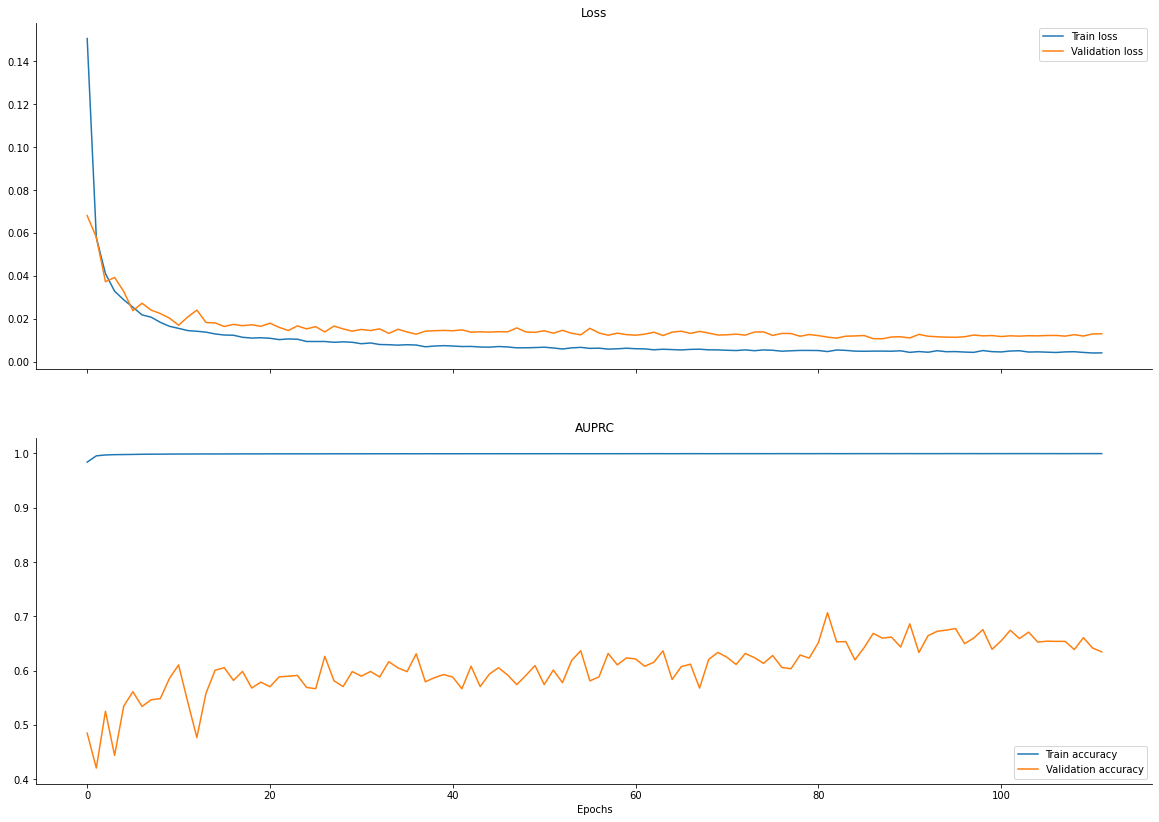

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['auprc'], label='Train accuracy')
ax2.plot(history['val_auprc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('AUPRC')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [ ]:
y_pred = model.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
TF_Model_AUPRC = auprc.result().numpy()
TF_Model_AUPRC

0.63654363

In [ ]:
TF_Model_metrics = compute_metrics(y_test, y_pred)
print_metrics(TF_Model_metrics)

Fraudulent Transactions Detected (True Positives): 41
Fraudulent Transactions Missed (False Negatives): 8
Legitimate Transactions Incorrectly Detected (False Positives): 52
Legitimate Transactions Detected (True Negatives): 28380


In [ ]:
print('RF_AUPRC: ' + str(RF_AUPRC))
print('XGB_AUPRC: ' + str(XGB_AUPRC))
print('TF_Model_AUPRC: ' + str(TF_Model_AUPRC))

RF_AUPRC: 0.7639222
XGB_AUPRC: 0.03585368
TF_Model_AUPRC: 0.63654363


In [ ]:
print('Random Forest ********************')
print_metrics(RF_metrics)
print('XGBoost **************************')
print_metrics(XGB_metrics)
print('TensorFlow DNN Model ************')
print_metrics(TF_Model_metrics)

Random Forest ********************
Fraudulent Transactions Detected (True Positives): 41
Fraudulent Transactions Missed (False Negatives): 8
Legitimate Transactions Incorrectly Detected (False Positives): 4
Legitimate Transactions Detected (True Negatives): 28428
XGBoost **************************
Fraudulent Transactions Detected (True Positives): 43
Fraudulent Transactions Missed (False Negatives): 6
Legitimate Transactions Incorrectly Detected (False Positives): 1029
Legitimate Transactions Detected (True Negatives): 27403
TensorFlow DNN Model ************
Fraudulent Transactions Detected (True Positives): 41
Fraudulent Transactions Missed (False Negatives): 8
Legitimate Transactions Incorrectly Detected (False Positives): 52
Legitimate Transactions Detected (True Negatives): 28380


In [ ]:
tp_df['Model'] = models
results = [RF_metrics[0], XGB_metrics[0], TF_Model_metrics[0]]
tp_df['ADASYN'] = results
fn_df['Model'] = models
results = [RF_metrics[1], XGB_metrics[1], TF_Model_metrics[1]]
fn_df['ADASYN'] = results
fp_df['Model'] = models
results = [RF_metrics[2], XGB_metrics[2], TF_Model_metrics[2]]
fp_df['ADASYN'] = results
tn_df['Model'] = models
results = [RF_metrics[3], XGB_metrics[3], TF_Model_metrics[3]]
tn_df['ADASYN'] = results

In [ ]:
results = [RF_AUPRC, XGB_AUPRC, TF_Model_AUPRC]
auprc_df['Oversampling ADASYN'] = results

# Combo (SMOTEENN)
 over-sampling using SMOTE (Synthetic Minority Over-sampling Technique) and cleaning using ENN (EditedNearestNeighbours) 

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = prep_data()

In [ ]:
%%time 
neg, pos = bincount(y_train)
print('Original balance: ' + str(neg) + ' non-fraud, ' + str(pos) + ' fraud')

from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=seed)
x_train, y_train = smote_enn.fit_resample(x_train, y_train)

neg, pos = bincount(y_train)
print('New balance: ' + str(neg) + ' non-fraud, ' + str(pos) + ' fraud')


Original balance: 230294 non-fraud, 399 fraud
New balance: 229893 non-fraud, 230294 fraud
CPU times: user 57min 31s, sys: 3min 31s, total: 1h 1min 3s
Wall time: 50min 40s


In [ ]:
classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=seed)
classifier.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=53)

In [ ]:
y_pred = classifier.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
RF_AUPRC = auprc.result().numpy()
RF_AUPRC

0.7360719

In [ ]:
RF_metrics = compute_metrics(y_test, y_pred)
print_metrics(RF_metrics)

Fraudulent Transactions Detected (True Positives): 42
Fraudulent Transactions Missed (False Negatives): 7
Legitimate Transactions Incorrectly Detected (False Positives): 7
Legitimate Transactions Detected (True Negatives): 28425


In [ ]:
%%time
xgbc = XGBClassifier(objective='binary:logistic', seed=seed, eval_metric='aucpr')
xgbc.fit(x_train, y_train)

CPU times: user 1min 44s, sys: 0 ns, total: 1min 44s
Wall time: 1min 44s


In [ ]:
y_pred = xgbc.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
XGB_AUPRC = auprc.result().numpy()
XGB_AUPRC

0.09986501

In [ ]:
XGB_metrics = compute_metrics(y_test, y_pred)
print_metrics(XGB_metrics)

Fraudulent Transactions Detected (True Positives): 42
Fraudulent Transactions Missed (False Negatives): 7
Legitimate Transactions Incorrectly Detected (False Positives): 322
Legitimate Transactions Detected (True Negatives): 28110


In [ ]:
model = create_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input1 (InputLayer)         [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 96)                2976      
                                                                 
 batch_normalization (BatchN  (None, 96)               384       
 ormalization)                                                   
                                                                 
 elu (ELU)                   (None, 96)                0         
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 96)                9312      
                                                             

In [ ]:
es = EarlyStopping(monitor='val_auprc', patience=30, verbose=1, mode='max',
                   restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=200, verbose=2, callbacks=[es], 
                    validation_data=(x_val, y_val), batch_size=BATCH_SIZE)

Epoch 1/200
1798/1798 - 10s - loss: 0.1250 - auroc: 0.9892 - auprc: 0.9907 - val_loss: 0.0548 - val_auroc: 0.9767 - val_auprc: 0.6945 - 10s/epoch - 6ms/step
Epoch 2/200
1798/1798 - 8s - loss: 0.0695 - auroc: 0.9969 - auprc: 0.9968 - val_loss: 0.0389 - val_auroc: 0.9716 - val_auprc: 0.6877 - 8s/epoch - 5ms/step
Epoch 3/200
1798/1798 - 9s - loss: 0.0506 - auroc: 0.9983 - auprc: 0.9980 - val_loss: 0.0339 - val_auroc: 0.9730 - val_auprc: 0.6416 - 9s/epoch - 5ms/step
Epoch 4/200
1798/1798 - 9s - loss: 0.0405 - auroc: 0.9988 - auprc: 0.9985 - val_loss: 0.0279 - val_auroc: 0.9739 - val_auprc: 0.6702 - 9s/epoch - 5ms/step
Epoch 5/200
1798/1798 - 8s - loss: 0.0352 - auroc: 0.9990 - auprc: 0.9987 - val_loss: 0.0265 - val_auroc: 0.9741 - val_auprc: 0.6526 - 8s/epoch - 5ms/step
Epoch 6/200
1798/1798 - 8s - loss: 0.0298 - auroc: 0.9992 - auprc: 0.9989 - val_loss: 0.0233 - val_auroc: 0.9746 - val_auprc: 0.6535 - 8s/epoch - 5ms/step
Epoch 7/200
1798/1798 - 8s - loss: 0.0263 - auroc: 0.9993 - auprc: 0

In [ ]:
model.evaluate(x_test, y_test)

891/891 [==============================] - 3s 3ms/step - loss: 0.0558 - auroc: 0.9881 - auprc: 0.7004


[0.055758997797966, 0.9881013035774231, 0.7004275918006897]

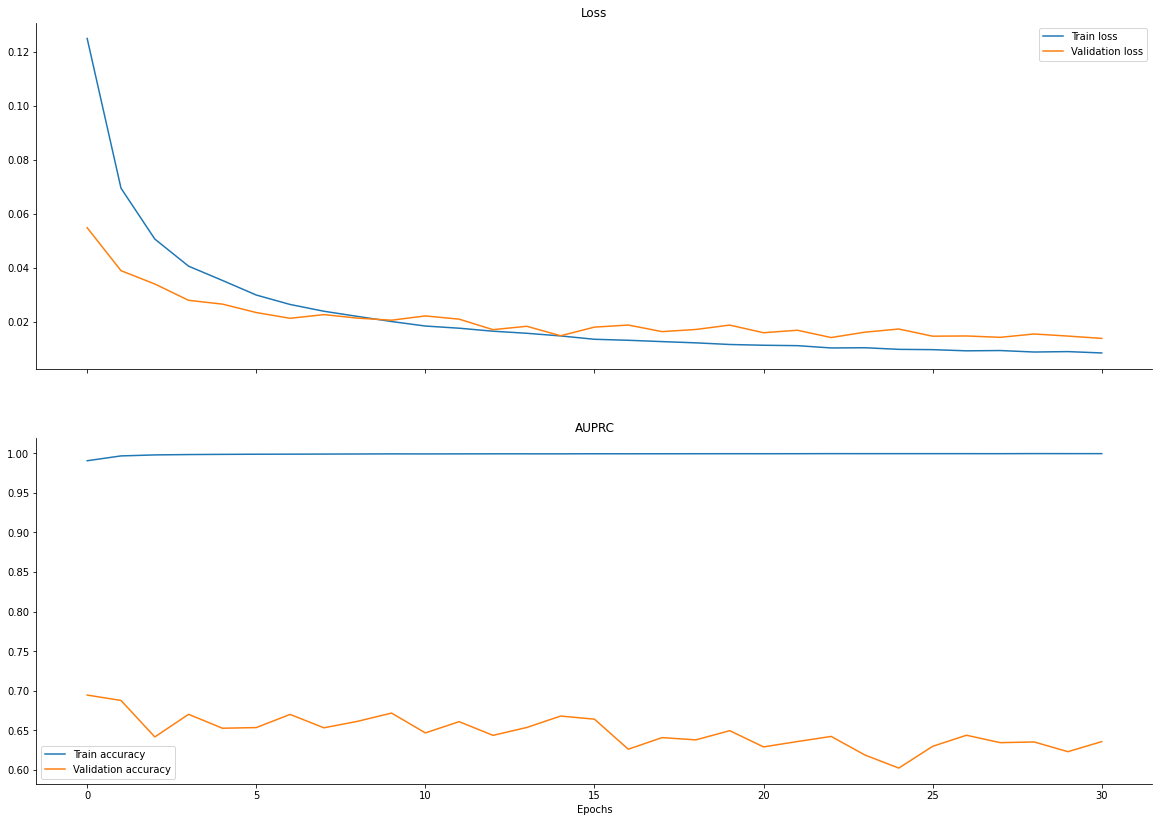

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['auprc'], label='Train accuracy')
ax2.plot(history['val_auprc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('AUPRC')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [ ]:
y_pred = model.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
TF_Model_AUPRC = auprc.result().numpy()
TF_Model_AUPRC

0.7004276

In [ ]:
TF_Model_metrics = compute_metrics(y_test, y_pred)
print_metrics(TF_Model_metrics)

Fraudulent Transactions Detected (True Positives): 43
Fraudulent Transactions Missed (False Negatives): 6
Legitimate Transactions Incorrectly Detected (False Positives): 471
Legitimate Transactions Detected (True Negatives): 27961


In [ ]:
print('RF_AUPRC: ' + str(RF_AUPRC))
print('XGB_AUPRC: ' + str(XGB_AUPRC))
print('TF_Model_AUPRC: ' + str(TF_Model_AUPRC))

RF_AUPRC: 0.7360719
XGB_AUPRC: 0.09986501
TF_Model_AUPRC: 0.7004276


In [ ]:
print('Random Forest ********************')
print_metrics(RF_metrics)
print('XGBoost **************************')
print_metrics(XGB_metrics)
print('TensorFlow DNN Model ************')
print_metrics(TF_Model_metrics)

Random Forest ********************
Fraudulent Transactions Detected (True Positives): 42
Fraudulent Transactions Missed (False Negatives): 7
Legitimate Transactions Incorrectly Detected (False Positives): 7
Legitimate Transactions Detected (True Negatives): 28425
XGBoost **************************
Fraudulent Transactions Detected (True Positives): 42
Fraudulent Transactions Missed (False Negatives): 7
Legitimate Transactions Incorrectly Detected (False Positives): 322
Legitimate Transactions Detected (True Negatives): 28110
TensorFlow DNN Model ************
Fraudulent Transactions Detected (True Positives): 43
Fraudulent Transactions Missed (False Negatives): 6
Legitimate Transactions Incorrectly Detected (False Positives): 471
Legitimate Transactions Detected (True Negatives): 27961


In [ ]:
tp_df['Model'] = models
results = [RF_metrics[0], XGB_metrics[0], TF_Model_metrics[0]]
tp_df['SMOTEENN'] = results
fn_df['Model'] = models
results = [RF_metrics[1], XGB_metrics[1], TF_Model_metrics[1]]
fn_df['SMOTEENN'] = results
fp_df['Model'] = models
results = [RF_metrics[2], XGB_metrics[2], TF_Model_metrics[2]]
fp_df['SMOTEENN'] = results
tn_df['Model'] = models
results = [RF_metrics[3], XGB_metrics[3], TF_Model_metrics[3]]
tn_df['SMOTEENN'] = results

In [ ]:
results = [RF_AUPRC, XGB_AUPRC, TF_Model_AUPRC]
auprc_df['Combo (SMOTEENN)'] = results

# AutoEncoder

Use an autoencoder for anamoly detection

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = prep_data()

temp = pd.DataFrame(x_train)
temp['target'] = y_train
train_f = temp[temp['target'] == 0]
train_t = temp[temp['target'] == 1]

temp = pd.DataFrame(x_val)
temp['target'] = y_val
val_f = temp[temp['target'] == 0]
val_t = temp[temp['target'] == 1]

temp = pd.DataFrame(x_test)
temp['target'] = y_test
test_f = temp[temp['target'] == 0]
test_t = temp[temp['target'] == 1]

x_train_f = train_f.drop('target', axis='columns').values
x_train_t = train_t.drop('target', axis='columns').values
x_val_f = val_f.drop('target', axis='columns').values
x_val_t = val_t.drop('target', axis='columns').values
x_test_f = test_f.drop('target', axis='columns').values
x_test_t = test_t.drop('target', axis='columns').values

In [ ]:
tf.keras.backend.clear_session()
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense

inp = Input(shape=(x_train.shape[1],))
x = Dense(64, activation='swish')(inp)
x = Dense(32, activation='swish')(x)
enc = Dense(25, activation='swish')(x)
x = Dense(28, activation='swish')(enc)
out = Dense(x_train.shape[1], activation='linear')(x)

model = Model(inp, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 64)                1984      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 25)                825       
                                                                 
 dense_3 (Dense)             (None, 28)                728       
                                                                 
 dense_4 (Dense)             (None, 30)                870       
                                                                 
Total params: 6,487
Trainable params: 6,487
Non-trainable par

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='mse', metrics=['mae'])
es = tf.keras.callbacks.EarlyStopping(patience=9, verbose=2, restore_best_weights=True)
history = model.fit(x_train_f, x_train_f, epochs=500, validation_data=(x_val_f, x_val_f),
                    callbacks=[es])

Epoch 1/500
7197/7197 [==============================] - 22s 3ms/step - loss: 0.1818 - mae: 0.2474 - val_loss: 0.0642 - val_mae: 0.1557
Epoch 2/500
7197/7197 [==============================] - 22s 3ms/step - loss: 0.0417 - mae: 0.1184 - val_loss: 0.0353 - val_mae: 0.1085
Epoch 3/500
7197/7197 [==============================] - 22s 3ms/step - loss: 0.0361 - mae: 0.1048 - val_loss: 0.0316 - val_mae: 0.0992
Epoch 4/500
7197/7197 [==============================] - 23s 3ms/step - loss: 0.0338 - mae: 0.0988 - val_loss: 0.0309 - val_mae: 0.0935
Epoch 5/500
7197/7197 [==============================] - 22s 3ms/step - loss: 0.0306 - mae: 0.0946 - val_loss: 0.0358 - val_mae: 0.0995
Epoch 6/500
7197/7197 [==============================] - 22s 3ms/step - loss: 0.0299 - mae: 0.0937 - val_loss: 0.0328 - val_mae: 0.1013
Epoch 7/500
7197/7197 [==============================] - 22s 3ms/step - loss: 0.0292 - mae: 0.0918 - val_loss: 0.0405 - val_mae: 0.1190
Epoch 8/500
7197/7197 [=========================

In [ ]:
mf = model.evaluate(x_train_f, x_train_f)
mt = model.evaluate(x_train_t, x_train_t)

13/13 [==============================] - 0s 2ms/step - loss: 16.9229 - mae: 2.2305


Determine what tolerance to use 

In [ ]:
mf = model.evaluate(x_val_f, x_val_f)
mt = model.evaluate(x_val_t, x_val_t)

2/2 [==============================] - 0s 7ms/step - loss: 18.9141 - mae: 2.3782


In [ ]:
reconstructions_f = model.predict(x_test_f)
reconstructions_t = model.predict(x_test_t)

In [ ]:
import numpy as np
mse_f = np.mean(np.power(x_test_f - reconstructions_f, 2), axis=1)
mse_t = np.mean(np.power(x_test_t - reconstructions_t, 2), axis=1)
print(np.median(mse_f))
print(np.median(mse_t))

0.001068795341363909
7.686214866323981


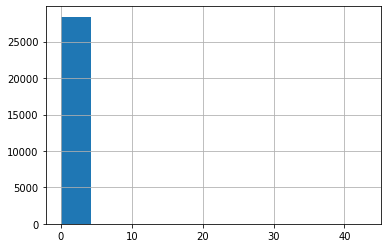

In [ ]:
pd.Series(mse_f).hist()

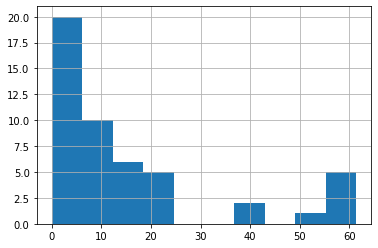

In [ ]:
pd.Series(mse_t).hist()

In [ ]:
x_preds = model.predict(x_test)
mse = np.mean(np.power(x_test - x_preds, 2), axis=1)
result = pd.DataFrame(mse, columns=['mse'])
result['target'] = result['mse'] > 2.5
y_pred = result.target.values

In [ ]:
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
TF_AutoEncoder_AUPRC = auprc.result().numpy()
TF_AutoEncoder_AUPRC

0.6806069

In [ ]:
TF_AutoEncoder_metrics = compute_metrics(y_test, y_pred)
print_metrics(TF_AutoEncoder_metrics)

Fraudulent Transactions Detected (True Positives): 42
Fraudulent Transactions Missed (False Negatives): 7
Legitimate Transactions Incorrectly Detected (False Positives): 11
Legitimate Transactions Detected (True Negatives): 28421


In [ ]:
results = [0., 0., TF_AutoEncoder_AUPRC]
auprc_df['AutoEncoder'] = results

# Results Summary

Best resulting AUPRC was our baseline DNN model. 



In [ ]:
neg, pos = bincount(y_test)
print(str(neg) + ' non-fraud, ' + str(pos) + ' fraud')

28432 non-fraud, 49 fraud


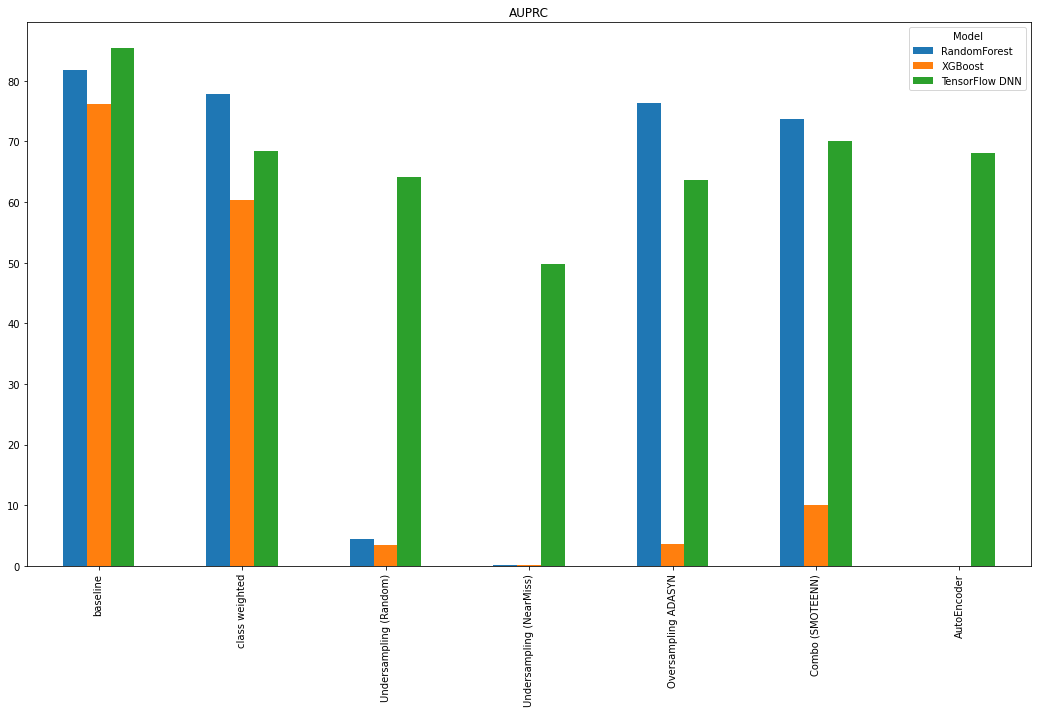

In [ ]:
a = auprc_df.copy(deep=True)
a.index = a.Model
a.drop(['Model'], axis='columns', inplace=True)
a = a.T
a['RandomForest'] = a['RandomForest']*100
a['XGBoost'] = a['XGBoost']*100
a['TensorFlow DNN'] = a['TensorFlow DNN']*100
ax = a.plot.bar(rot=90, figsize=(18, 10), title='AUPRC')

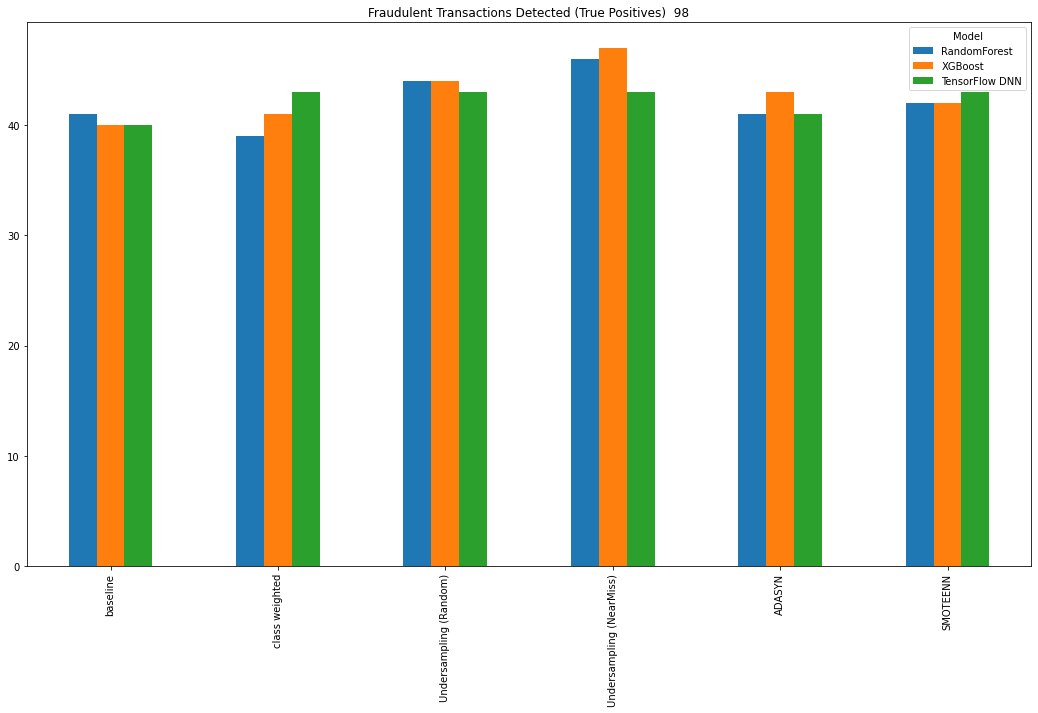

In [ ]:
a = tp_df.copy(deep=True)
a.index = a.Model
a.drop(['Model'], axis='columns', inplace=True)
a = a.T
a['RandomForest'] = a['RandomForest']
a['XGBoost'] = a['XGBoost']
a['TensorFlow DNN'] = a['TensorFlow DNN']
ax = a.plot.bar(rot=90, figsize=(18, 10), title='Fraudulent Transactions Detected (True Positives)  98')

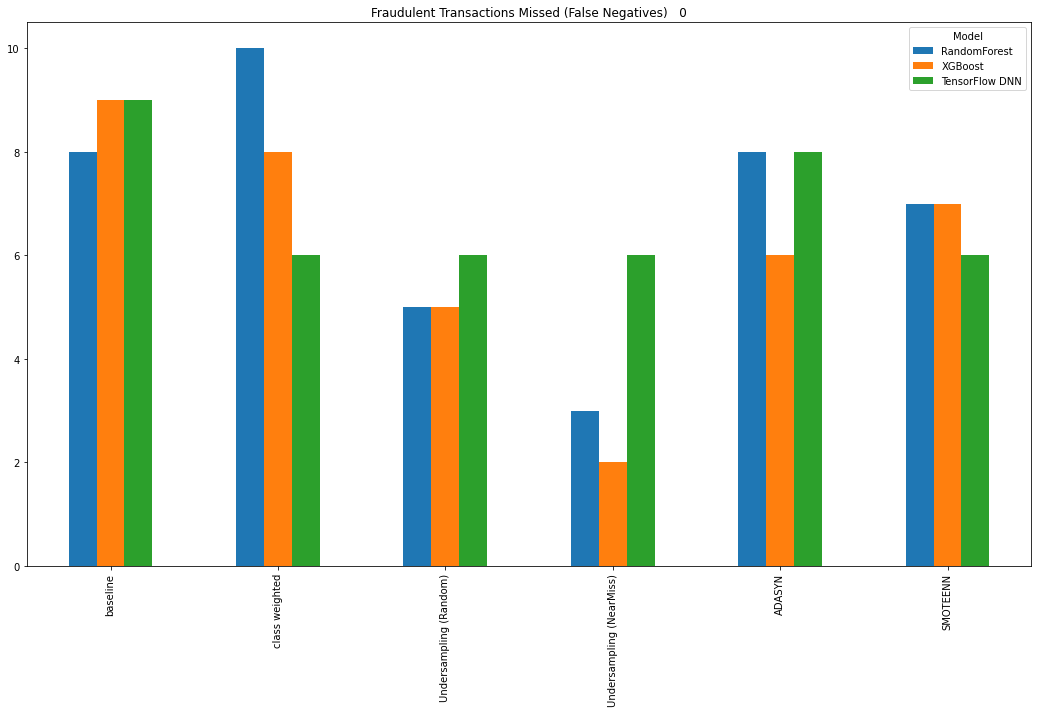

In [ ]:
a = fn_df.copy(deep=True)
a.index = a.Model
a.drop(['Model'], axis='columns', inplace=True)
a = a.T
a['RandomForest'] = a['RandomForest']
a['XGBoost'] = a['XGBoost']
a['TensorFlow DNN'] = a['TensorFlow DNN']
ax = a.plot.bar(rot=90, figsize=(18, 10), title='Fraudulent Transactions Missed (False Negatives)   0')

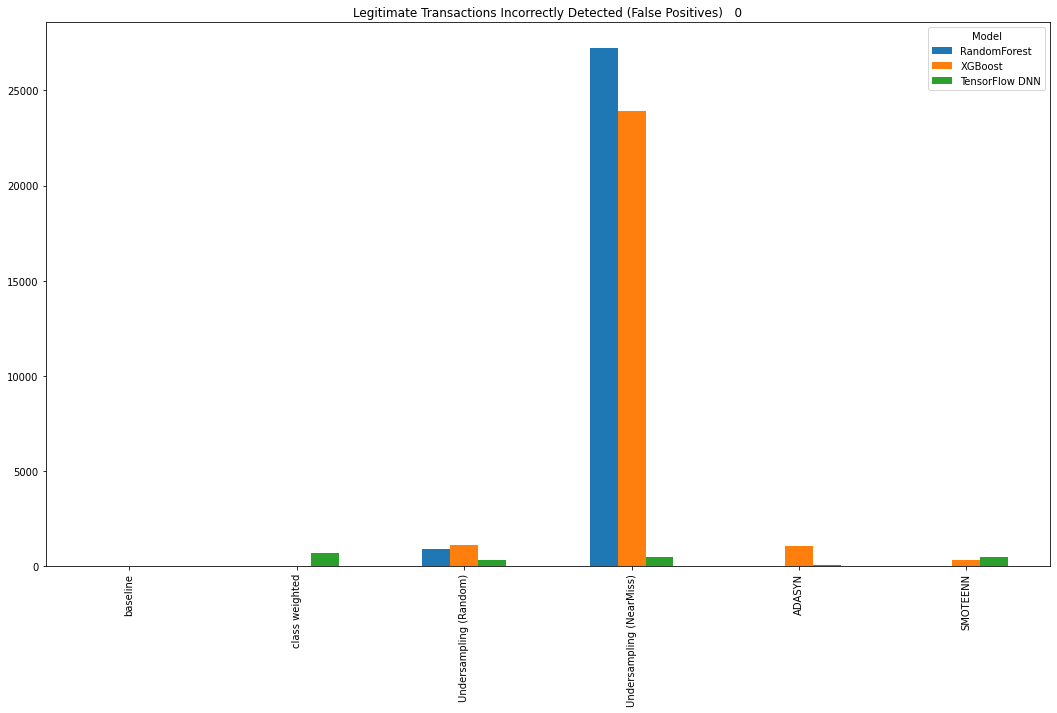

In [ ]:
a = fp_df.copy(deep=True)
a.index = a.Model
a.drop(['Model'], axis='columns', inplace=True)
a = a.T
a['RandomForest'] = a['RandomForest']
a['XGBoost'] = a['XGBoost']
a['TensorFlow DNN'] = a['TensorFlow DNN']
ax = a.plot.bar(rot=90, figsize=(18, 10), title='Legitimate Transactions Incorrectly Detected (False Positives)   0')

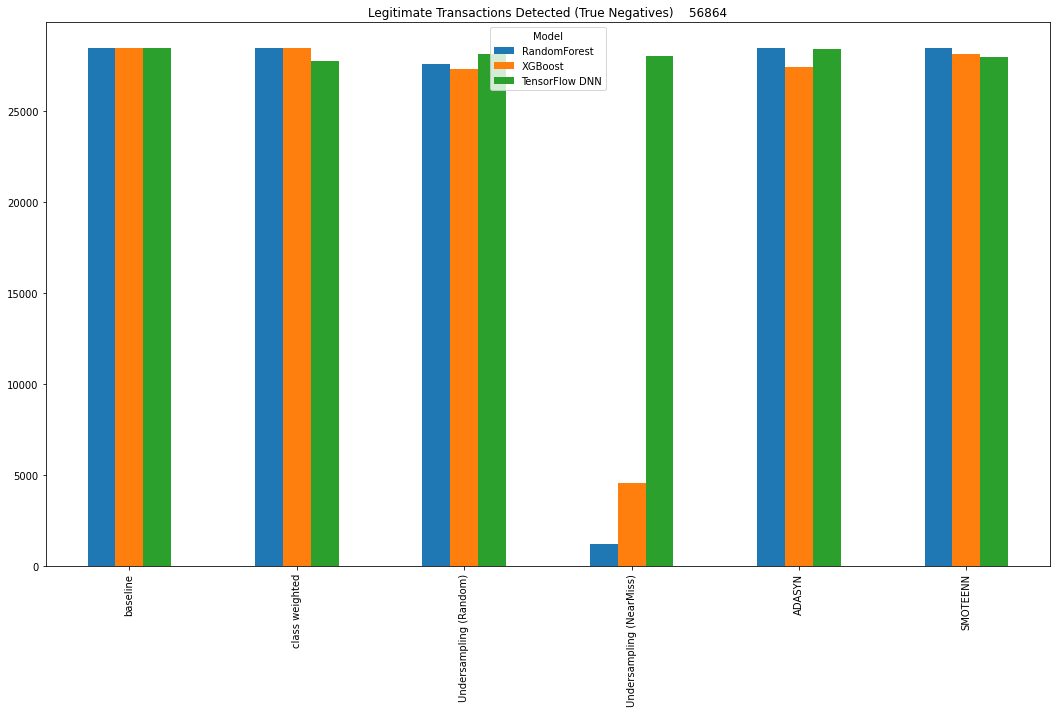

In [ ]:
a = tn_df.copy(deep=True)
a.index = a.Model
a.drop(['Model'], axis='columns', inplace=True)
a = a.T
a['RandomForest'] = a['RandomForest']
a['XGBoost'] = a['XGBoost']
a['TensorFlow DNN'] = a['TensorFlow DNN']
ax = a.plot.bar(rot=90, figsize=(18, 10), title='Legitimate Transactions Detected (True Negatives)    56864')